## Convolutional Neural Network for multi-class classificaiton on MNIST fashion dataset

### First step: loading libraries
run:
`pip install torch torchvision numpy matplotlib`

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Subset


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device.__str__().upper()}")

Using: CUDA


### Downloading fashion MNIST dataset using pytorch

In [3]:
# training set
dataset = torchvision.datasets.FashionMNIST(
    root="./",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

# set for model performance evaluation 
evalset = torchvision.datasets.FashionMNIST(
    root="./",
    train=False,
    transform=transforms.ToTensor(),
    download=False,
)


In [4]:

print(type(dataset))
print(dataset.data.shape)

<class 'torchvision.datasets.mnist.FashionMNIST'>
torch.Size([60000, 28, 28])


### Validation/Training split

In [5]:
print(len(dataset)) # 60_000

validation = Subset(dataset, torch.arange(10000))
training = Subset(dataset, torch.arange(10000, len(dataset)))


60000


In [6]:
print(type(validation))

<class 'torch.utils.data.dataset.Subset'>


### Configure loading of data into the future model

In [7]:
torch.manual_seed(1)  # numgen seed
batch_size = 64

# shuffle for more diversity in batches
train_loader = DataLoader(
    training,
    batch_size,
    shuffle=True,
)

validation_loader = DataLoader(
    validation,
    batch_size,
    shuffle=False,
)


### Model creation

In [8]:
test_shape = torch.ones((2, 1, 28, 28))

model = nn.Sequential()

model.add_module(
    "Convolution_1",
    nn.Conv2d(
        in_channels=1,
        out_channels=64,
        kernel_size=7,
        padding="same",
    ),
)

model.add_module("Relu_1", nn.ReLU())

print(model(test_shape).shape)

model.add_module("Pool_1", nn.MaxPool2d(kernel_size=2))

print(model(test_shape).shape)

model.add_module(
    "Convolution_2",
    nn.Conv2d(
        in_channels=64,
        out_channels=128,
        kernel_size=3,
        padding="same",
    ),
)

model.add_module("Relu_2", nn.ReLU())

print(model(test_shape).shape)

model.add_module(
    "Convolution_3",
    nn.Conv2d(
        in_channels=128,
        out_channels=128,
        kernel_size=3,
        padding="same",
    ),
)

model.add_module("Relu_3", nn.ReLU())

print(model(test_shape).shape)

model.add_module("Pool_2", nn.MaxPool2d(kernel_size=2))

print(model(test_shape).shape)

model.add_module(
    "Convolution_4",
    nn.Conv2d(
        in_channels=128,
        out_channels=256,
        kernel_size=3,
        padding="same",
    ),
)

model.add_module("Relu_4", nn.ReLU())

print(model(test_shape).shape)

model.add_module(
    "Convolution_5",
    nn.Conv2d(
        in_channels=256,
        out_channels=256,
        kernel_size=3,
        padding="same",
    ),
)

model.add_module("Relu_5", nn.ReLU())

print(model(test_shape).shape)

model.add_module("Pool_3", nn.MaxPool2d(kernel_size=2))

print(model(test_shape).shape)

model.add_module('Flatten', nn.Flatten())

print(model(test_shape).shape)

model.add_module("FC_1", nn.Linear(256 * 3 * 3, 128))
model.add_module("Relu_6", nn.ReLU())
model.add_module("dropout_1", nn.Dropout(0.5))
model.add_module("FC_2", nn.Linear(128, 64))
model.add_module("Relu_7", nn.ReLU())
model.add_module("dropout_2", nn.Dropout(0.5))
model.add_module("FC_3", nn.Linear(64, 10))


print(model(test_shape).shape)
print(model(test_shape))

torch.Size([2, 64, 28, 28])
torch.Size([2, 64, 14, 14])
torch.Size([2, 128, 14, 14])
torch.Size([2, 128, 14, 14])
torch.Size([2, 128, 7, 7])
torch.Size([2, 256, 7, 7])
torch.Size([2, 256, 7, 7])
torch.Size([2, 256, 3, 3])
torch.Size([2, 2304])
torch.Size([2, 10])
tensor([[ 0.1206,  0.1121, -0.1048, -0.0698, -0.0943, -0.1688,  0.1246,  0.0670,
         -0.0523,  0.1076],
        [ 0.1029,  0.1019, -0.0285, -0.0723, -0.0945, -0.1673,  0.1610,  0.0513,
         -0.0539,  0.0782]], grad_fn=<AddmmBackward0>)


In [9]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())


In [10]:
def train(model, num_epochs, train_dl, valid_dl):
    model = model.to(device)
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs

    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)

            loss = loss_fn(pred, y_batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)

            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()

            accuracy_hist_train[epoch] += is_correct.sum().item()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)

                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)

                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().item()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(
            f"Epoch {epoch+1}: \n train_acc = {accuracy_hist_train[epoch]:.4f} \n valid_acc = {accuracy_hist_valid[epoch]:.4f}"
        )

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [16]:
epochs = 20
inference = train(
    model,
    epochs,
    train_loader,
    validation_loader,
)


Epoch 1: 
 train_acc = 0.9087 
 valid_acc = 0.9066
Epoch 2: 
 train_acc = 0.9155 
 valid_acc = 0.9134
Epoch 3: 
 train_acc = 0.9186 
 valid_acc = 0.9048
Epoch 4: 
 train_acc = 0.9239 
 valid_acc = 0.9179
Epoch 5: 
 train_acc = 0.9275 
 valid_acc = 0.9173
Epoch 6: 
 train_acc = 0.9306 
 valid_acc = 0.9102
Epoch 7: 
 train_acc = 0.9323 
 valid_acc = 0.9191
Epoch 8: 
 train_acc = 0.9394 
 valid_acc = 0.9202
Epoch 9: 
 train_acc = 0.9411 
 valid_acc = 0.9165
Epoch 10: 
 train_acc = 0.9418 
 valid_acc = 0.9119
Epoch 11: 
 train_acc = 0.9475 
 valid_acc = 0.9111
Epoch 12: 
 train_acc = 0.9504 
 valid_acc = 0.9186
Epoch 13: 
 train_acc = 0.9524 
 valid_acc = 0.9222
Epoch 14: 
 train_acc = 0.9540 
 valid_acc = 0.9161
Epoch 15: 
 train_acc = 0.9568 
 valid_acc = 0.9215
Epoch 16: 
 train_acc = 0.9583 
 valid_acc = 0.9142
Epoch 17: 
 train_acc = 0.9601 
 valid_acc = 0.9172
Epoch 18: 
 train_acc = 0.9582 
 valid_acc = 0.9172
Epoch 19: 
 train_acc = 0.9644 
 valid_acc = 0.9144
Epoch 20: 
 train_acc

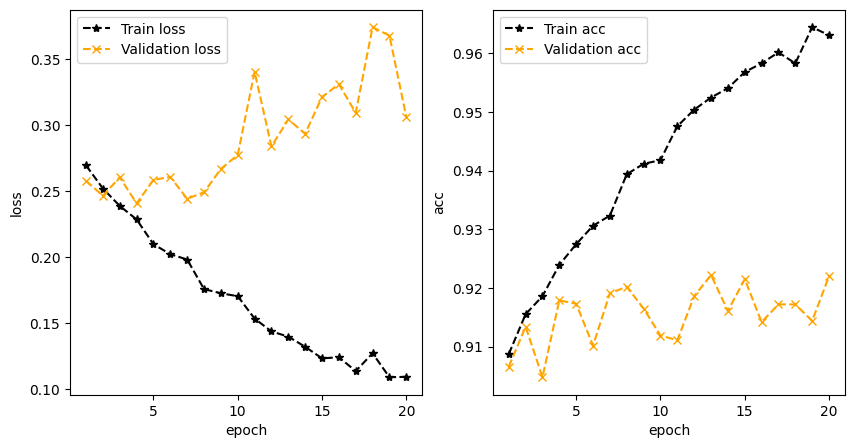

In [17]:
x_arr = np.arange(len(inference[0])) + 1
fig = plt.figure(figsize=(10, 5))

# loss
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, inference[0], "--*", label="Train loss", color="black")
ax.plot(x_arr, inference[1], "--x", label="Validation loss", color="orange")
ax.legend()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.xaxis.get_major_locator().set_params(integer=True)

# acc
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, inference[2], "--*", label="Train acc", color="black")
ax.plot(x_arr, inference[3], "--x", label="Validation acc", color="orange")
ax.legend()
ax.set_xlabel("epoch")
ax.set_ylabel("acc")
ax.xaxis.get_major_locator().set_params(integer=True)

plt.show()
